In [1]:
# Imports, random seed, and device configuration
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset
import numpy as np
import random
import time
import math
import matplotlib.pyplot as plt
import seaborn as sns

# Set random seed for reproducibility
random_seed = 42
random.seed(random_seed)
np.random.seed(random_seed)
torch.manual_seed(random_seed)
if torch.cuda.is_available():
    torch.cuda.manual_seed_all(random_seed)
    
# make cudnn deterministic
# torch.backends.cudnn.deterministic = True
# torch.backends.cudnn.benchmark = False

# Set device to GPU if available, otherwise CPU
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [2]:
# Load translation dataset from file ("Dataset-English_to_French.txt")
with open("Dataset-English_to_French.txt", "r", encoding="utf-8") as f:
    data_str = f.read()
exec(data_str)  # This defines variable 'english_to_french'

# Build word-level vocabulary from English and French sentences (union of both languages)
all_words = []
for eng, fr in english_to_french:
    all_words.extend(eng.split())
    all_words.extend(fr.split())
vocab = sorted(list(set(all_words)))
# Define special tokens: SOS (start) and EOS (end)
SOS_token = 0
EOS_token = 1
word_to_index = {"SOS": SOS_token, "EOS": EOS_token}
for i, word in enumerate(vocab):
    word_to_index[word] = i + 2
index_to_word = {i: word for word, i in word_to_index.items()}
print("Vocabulary size:", len(word_to_index))
# Print sample data to verify
print("\nSample data (first 5):")
for i, sample in enumerate(english_to_french[:5]):
    print(f"Sample {i+1}:", sample)

Vocabulary size: 511

Sample data (first 5):
Sample 1: ('I am cold', "J'ai froid")
Sample 2: ('You are tired', 'Tu es fatigué')
Sample 3: ('He is hungry', 'Il a faim')
Sample 4: ('She is happy', 'Elle est heureuse')
Sample 5: ('We are friends', 'Nous sommes amis')


In [3]:
# Define custom Dataset for French-to-English translation (word-based)
# For p4, we swap the order: Input: French, Target: English.
class TranslationDataset(Dataset):
    def __init__(self, data, word_to_index):
        self.data = data
        self.word_to_index = word_to_index

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        eng, fr = self.data[idx]  # original tuple: (English, French)
        # For French-to-English, use French as input and English as target.
        input_tensor = torch.tensor([self.word_to_index[word] for word in fr.split()] + [EOS_token], dtype=torch.long)
        target_tensor = torch.tensor([self.word_to_index[word] for word in eng.split()] + [EOS_token], dtype=torch.long)
        return input_tensor, target_tensor

dataset = TranslationDataset(english_to_french, word_to_index)
dataloader = DataLoader(dataset, batch_size=1, shuffle=True)

In [4]:
# RNN-based GRU Encoder-Decoder (Without Attention)
# Define GRU-based Encoder (word-based)
class EncoderGRU(nn.Module):
    def __init__(self, input_size, hidden_size):
        super(EncoderGRU, self).__init__()
        self.hidden_size = hidden_size
        self.embedding = nn.Embedding(input_size, hidden_size)
        self.gru = nn.GRU(hidden_size, hidden_size)
    def forward(self, input, hidden):
        # Embed input and reshape to (1,1,hidden)
        embedded = self.embedding(input).view(1, 1, -1)
        output, hidden = self.gru(embedded, hidden)
        return output, hidden
    def initHidden(self):
        return torch.zeros(1, 1, self.hidden_size, device=device)

# Define GRU-based Decoder (word-based) without attention
class DecoderGRU(nn.Module):
    def __init__(self, hidden_size, output_size):
        super(DecoderGRU, self).__init__()
        self.hidden_size = hidden_size
        self.embedding = nn.Embedding(output_size, hidden_size)
        self.gru = nn.GRU(hidden_size, hidden_size)
        self.out = nn.Linear(hidden_size, output_size)
        self.softmax = nn.LogSoftmax(dim=1)
    def forward(self, input, hidden):
        embedded = self.embedding(input).view(1, 1, -1)
        output, hidden = self.gru(embedded, hidden)
        output = self.softmax(self.out(output[0]))
        return output, hidden
    def initHidden(self):
        return torch.zeros(1, 1, self.hidden_size, device=device)

# Instantiate models for RNN baseline (without attention)
input_size = len(word_to_index)
hidden_size = 256
output_size = len(word_to_index)
encoder_gru = EncoderGRU(input_size, hidden_size).to(device)
decoder_gru = DecoderGRU(hidden_size, output_size).to(device)

In [5]:
# Training and evaluation functions for RNN (without attention)
def train_rnn(input_tensor, target_tensor, encoder, decoder, encoder_optimizer, decoder_optimizer, criterion):
    input_tensor = input_tensor.squeeze(0)
    target_tensor = target_tensor.squeeze(0)
    encoder_hidden = encoder.initHidden()
    encoder_optimizer.zero_grad()
    decoder_optimizer.zero_grad()
    input_length = input_tensor.size(0)
    target_length = target_tensor.size(0)
    loss = 0
    # Encoder pass
    for ei in range(input_length):
        encoder_output, encoder_hidden = encoder(input_tensor[ei].unsqueeze(0), encoder_hidden)
    # Decoder pass starting with SOS token
    decoder_input = torch.tensor([SOS_token], device=device)
    decoder_hidden = encoder_hidden
    predicted_indices = []
    for di in range(target_length):
        decoder_output, decoder_hidden = decoder(decoder_input, decoder_hidden)
        loss += criterion(decoder_output, target_tensor[di].unsqueeze(0))
        topv, topi = decoder_output.topk(1)
        predicted_indices.append(topi.item())
        decoder_input = topi.squeeze().detach()
        if decoder_input.item() == EOS_token:
            break
    loss.backward()
    encoder_optimizer.step()
    decoder_optimizer.step()
    return loss.item() / target_length, predicted_indices

def evaluate_rnn(encoder, decoder, dataloader, criterion):
    encoder.eval()
    decoder.eval()
    total_loss = 0
    total_correct = 0
    total_tokens = 0
    total_samples = 0
    with torch.no_grad():
        for input_tensor, target_tensor in dataloader:
            input_tensor = input_tensor.squeeze(0).to(device)
            target_tensor = target_tensor.squeeze(0).to(device)
            encoder_hidden = encoder.initHidden()
            input_length = input_tensor.size(0)
            target_length = target_tensor.size(0)
            loss = 0
            predicted_indices = []
            for ei in range(input_length):
                encoder_output, encoder_hidden = encoder(input_tensor[ei].unsqueeze(0), encoder_hidden)
            decoder_input = torch.tensor([SOS_token], device=device)
            decoder_hidden = encoder_hidden
            for di in range(target_length):
                decoder_output, decoder_hidden = decoder(decoder_input, decoder_hidden)
                loss += criterion(decoder_output, target_tensor[di].unsqueeze(0))
                topv, topi = decoder_output.topk(1)
                predicted_indices.append(topi.item())
                decoder_input = topi.squeeze().detach()
                if decoder_input.item() == EOS_token:
                    break
            total_loss += loss.item() / target_length
            correct = sum(1 for i in range(target_length) if i < len(predicted_indices) and predicted_indices[i] == target_tensor[i].item())
            total_correct += correct
            total_tokens += target_length
            total_samples += 1
    avg_loss = total_loss / total_samples
    accuracy = total_correct / total_tokens
    return avg_loss, accuracy

In [6]:
# Training loop for RNN (without attention)
encoder_optimizer = optim.SGD(encoder_gru.parameters(), lr=0.01)
decoder_optimizer = optim.SGD(decoder_gru.parameters(), lr=0.01)
criterion = nn.NLLLoss()

n_epochs = 100
rnn_train_losses = []
rnn_val_losses = []
rnn_val_accuracies = []

for epoch in range(n_epochs):
    total_loss = 0
    encoder_gru.train()
    decoder_gru.train()
    for input_tensor, target_tensor in dataloader:
        input_tensor = input_tensor.to(device)
        target_tensor = target_tensor.to(device)
        loss, _ = train_rnn(input_tensor, target_tensor, encoder_gru, decoder_gru, encoder_optimizer, decoder_optimizer, criterion)
        total_loss += loss
    avg_train_loss = total_loss / len(dataloader)
    rnn_train_losses.append(avg_train_loss)
    val_loss, val_acc = evaluate_rnn(encoder_gru, decoder_gru, dataloader, criterion)
    rnn_val_losses.append(val_loss)
    rnn_val_accuracies.append(val_acc)
    print(f"[RNN] Epoch {epoch+1}: Train Loss: {avg_train_loss:.4f}, Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.4f}")

[RNN] Epoch 1: Train Loss: 3.7292, Val Loss: 3.3851, Val Acc: 0.0972
[RNN] Epoch 2: Train Loss: 3.3536, Val Loss: 2.4818, Val Acc: 0.0643
[RNN] Epoch 3: Train Loss: 3.4262, Val Loss: 3.2895, Val Acc: 0.0956
[RNN] Epoch 4: Train Loss: 3.3945, Val Loss: 3.0849, Val Acc: 0.0906
[RNN] Epoch 5: Train Loss: 3.3610, Val Loss: 2.9381, Val Acc: 0.0972
[RNN] Epoch 6: Train Loss: 3.3450, Val Loss: 2.9456, Val Acc: 0.1549
[RNN] Epoch 7: Train Loss: 3.1316, Val Loss: 2.7516, Val Acc: 0.1565
[RNN] Epoch 8: Train Loss: 3.0122, Val Loss: 2.8560, Val Acc: 0.2405
[RNN] Epoch 9: Train Loss: 2.9741, Val Loss: 2.9534, Val Acc: 0.3344
[RNN] Epoch 10: Train Loss: 2.8649, Val Loss: 2.4938, Val Acc: 0.3048
[RNN] Epoch 11: Train Loss: 2.7195, Val Loss: 2.2661, Val Acc: 0.2867
[RNN] Epoch 12: Train Loss: 2.5361, Val Loss: 2.2540, Val Acc: 0.3575
[RNN] Epoch 13: Train Loss: 2.4591, Val Loss: 2.1469, Val Acc: 0.3723
[RNN] Epoch 14: Train Loss: 2.2421, Val Loss: 2.0765, Val Acc: 0.4135
[RNN] Epoch 15: Train Loss: 2

In [7]:
# RNN-based GRU Encoder-Decoder with Attention
# Define Attention-based Decoder
class AttnDecoderGRU(nn.Module):
    def __init__(self, hidden_size, output_size, max_length=50, dropout_p=0.1):
        super(AttnDecoderGRU, self).__init__()
        self.hidden_size = hidden_size
        self.output_size = output_size
        self.max_length = max_length
        self.embedding = nn.Embedding(output_size, hidden_size)
        self.attn = nn.Linear(hidden_size * 2, max_length)
        self.attn_combine = nn.Linear(hidden_size * 2, hidden_size)
        self.dropout = nn.Dropout(dropout_p)
        self.gru = nn.GRU(hidden_size, hidden_size)
        self.out = nn.Linear(hidden_size, output_size)
        self.softmax = nn.LogSoftmax(dim=1)
    def forward(self, input, hidden, encoder_outputs):
        embedded = self.embedding(input).view(1, 1, -1)
        embedded = self.dropout(embedded)
        attn_input = torch.cat((embedded[0], hidden[0]), 1)  # (1, hidden*2)
        attn_weights = torch.softmax(self.attn(attn_input), dim=1)  # (1, max_length)
        attn_weights_unsqueezed = attn_weights.unsqueeze(1)  # (1, 1, max_length)
        encoder_outputs_unsqueezed = encoder_outputs.unsqueeze(0)  # (1, max_length, hidden)
        context = torch.bmm(attn_weights_unsqueezed, encoder_outputs_unsqueezed)  # (1,1,hidden)
        output = torch.cat((embedded[0], context[0]), 1)
        output = self.attn_combine(output).unsqueeze(0)
        output = torch.relu(output)
        output, hidden = self.gru(output, hidden)
        output = self.softmax(self.out(output[0]))
        return output, hidden, attn_weights
    def initHidden(self):
        return torch.zeros(1, 1, self.hidden_size, device=device)

# Instantiate models for attention version
encoder_attn = EncoderGRU(input_size, hidden_size).to(device)
decoder_attn = AttnDecoderGRU(hidden_size, output_size, max_length=50, dropout_p=0.1).to(device)

In [8]:
# Training and evaluation functions for attention model
def train_attn(input_tensor, target_tensor, encoder, decoder, encoder_optimizer, decoder_optimizer, criterion, max_length=50):
    input_tensor = input_tensor.squeeze(0)
    target_tensor = target_tensor.squeeze(0)
    encoder_hidden = encoder.initHidden()
    encoder_optimizer.zero_grad()
    decoder_optimizer.zero_grad()
    input_length = input_tensor.size(0)
    target_length = target_tensor.size(0)
    encoder_outputs = torch.zeros(max_length, encoder.hidden_size, device=device)
    loss = 0
    for ei in range(input_length):
        encoder_output, encoder_hidden = encoder(input_tensor[ei].unsqueeze(0), encoder_hidden)
        if ei < max_length:
            encoder_outputs[ei] = encoder_output[0, 0]
    decoder_input = torch.tensor([SOS_token], device=device)
    decoder_hidden = encoder_hidden
    predicted_indices = []
    for di in range(target_length):
        decoder_output, decoder_hidden, attn_weights = decoder(decoder_input, decoder_hidden, encoder_outputs)
        loss += criterion(decoder_output, target_tensor[di].unsqueeze(0))
        topv, topi = decoder_output.topk(1)
        predicted_indices.append(topi.item())
        decoder_input = topi.squeeze().detach()
        if decoder_input.item() == EOS_token:
            break
    loss.backward()
    encoder_optimizer.step()
    decoder_optimizer.step()
    return loss.item() / target_length, predicted_indices

def evaluate_attn(encoder, decoder, dataloader, criterion, max_length=50):
    encoder.eval()
    decoder.eval()
    total_loss = 0
    total_correct = 0
    total_tokens = 0
    total_samples = 0
    with torch.no_grad():
        for input_tensor, target_tensor in dataloader:
            input_tensor = input_tensor.squeeze(0).to(device)
            target_tensor = target_tensor.squeeze(0).to(device)
            encoder_hidden = encoder.initHidden()
            input_length = input_tensor.size(0)
            target_length = target_tensor.size(0)
            encoder_outputs = torch.zeros(max_length, encoder.hidden_size, device=device)
            loss = 0
            predicted_indices = []
            for ei in range(input_length):
                encoder_output, encoder_hidden = encoder(input_tensor[ei].unsqueeze(0), encoder_hidden)
                if ei < max_length:
                    encoder_outputs[ei] = encoder_output[0, 0]
            decoder_input = torch.tensor([SOS_token], device=device)
            decoder_hidden = encoder_hidden
            for di in range(target_length):
                decoder_output, decoder_hidden, attn_weights = decoder(decoder_input, decoder_hidden, encoder_outputs)
                loss += criterion(decoder_output, target_tensor[di].unsqueeze(0))
                topv, topi = decoder_output.topk(1)
                predicted_indices.append(topi.item())
                decoder_input = topi.squeeze().detach()
                if decoder_input.item() == EOS_token:
                    break
            total_loss += loss.item() / target_length
            correct = sum(1 for i in range(target_length) if i < len(predicted_indices) and predicted_indices[i] == target_tensor[i].item())
            total_correct += correct
            total_tokens += target_length
            total_samples += 1
    avg_loss = total_loss / total_samples
    accuracy = total_correct / total_tokens
    return avg_loss, accuracy

In [9]:
# Training loop for attention model
encoder_attn_optimizer = optim.SGD(encoder_attn.parameters(), lr=0.01)
decoder_attn_optimizer = optim.SGD(decoder_attn.parameters(), lr=0.01)
criterion_attn = nn.NLLLoss()

attn_train_losses = []
attn_val_losses = []
attn_val_accuracies = []
for epoch in range(n_epochs):
    total_loss = 0
    encoder_attn.train()
    decoder_attn.train()
    for input_tensor, target_tensor in dataloader:
        input_tensor = input_tensor.to(device)
        target_tensor = target_tensor.to(device)
        loss, _ = train_attn(input_tensor, target_tensor, encoder_attn, decoder_attn,
                              encoder_attn_optimizer, decoder_attn_optimizer, criterion_attn, max_length=50)
        total_loss += loss
    avg_train_loss = total_loss / len(dataloader)
    attn_train_losses.append(avg_train_loss)
    val_loss, val_acc = evaluate_attn(encoder_attn, decoder_attn, dataloader, criterion_attn, max_length=50)
    attn_val_losses.append(val_loss)
    attn_val_accuracies.append(val_acc)
    print(f"[Attn] Epoch {epoch+1}: Train Loss: {avg_train_loss:.4f}, Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.4f}")

[Attn] Epoch 1: Train Loss: 3.7213, Val Loss: 2.6385, Val Acc: 0.0395
[Attn] Epoch 2: Train Loss: 3.0992, Val Loss: 3.3844, Val Acc: 0.0906
[Attn] Epoch 3: Train Loss: 3.2607, Val Loss: 2.3392, Val Acc: 0.0362
[Attn] Epoch 4: Train Loss: 3.3206, Val Loss: 3.0806, Val Acc: 0.1104
[Attn] Epoch 5: Train Loss: 3.3646, Val Loss: 2.9989, Val Acc: 0.1285
[Attn] Epoch 6: Train Loss: 3.2343, Val Loss: 3.2675, Val Acc: 0.2652
[Attn] Epoch 7: Train Loss: 3.0830, Val Loss: 2.6773, Val Acc: 0.2241
[Attn] Epoch 8: Train Loss: 2.9833, Val Loss: 2.9443, Val Acc: 0.2916
[Attn] Epoch 9: Train Loss: 2.8936, Val Loss: 2.8472, Val Acc: 0.3509
[Attn] Epoch 10: Train Loss: 2.7256, Val Loss: 2.5725, Val Acc: 0.3542
[Attn] Epoch 11: Train Loss: 2.6499, Val Loss: 2.6084, Val Acc: 0.4069
[Attn] Epoch 12: Train Loss: 2.4500, Val Loss: 2.3501, Val Acc: 0.4333
[Attn] Epoch 13: Train Loss: 2.3043, Val Loss: 2.0186, Val Acc: 0.4119
[Attn] Epoch 14: Train Loss: 2.1285, Val Loss: 1.8538, Val Acc: 0.4596
[Attn] Epoch 15

In [10]:
# New dataset for Transformer which adds SOS token to target sequence (for French-to-English)
class TranslationDatasetTransformer(Dataset):
    def __init__(self, data, word_to_index):
        self.data = data
        self.word_to_index = word_to_index

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        eng, fr = self.data[idx]  # original tuple: (English, French)
        # For French-to-English, input is French (with EOS) and target is SOS + English + EOS
        input_tensor = torch.tensor([self.word_to_index[word] for word in fr.split()] + [EOS_token], dtype=torch.long)
        target_tensor = torch.tensor([SOS_token] + [self.word_to_index[word] for word in eng.split()] + [EOS_token], dtype=torch.long)
        return input_tensor, target_tensor

# Create the dataloader for Transformer using the new dataset
transformer_dataset = TranslationDatasetTransformer(english_to_french, word_to_index)
transformer_dataloader = DataLoader(transformer_dataset, batch_size=1, shuffle=True)

In [11]:
# Transformer-based Encoder-Decoder
# Define Positional Encoding module
class PositionalEncoding(nn.Module):
    def __init__(self, d_model, dropout=0.1, max_len=5000):
        super(PositionalEncoding, self).__init__()
        self.dropout = nn.Dropout(dropout)
        pe = torch.zeros(max_len, d_model)  # (max_len, d_model)
        position = torch.arange(0, max_len, dtype=torch.float).unsqueeze(1)
        div_term = torch.exp(torch.arange(0, d_model, 2).float() * (-math.log(10000.0) / d_model))
        pe[:, 0::2] = torch.sin(position * div_term)
        pe[:, 1::2] = torch.cos(position * div_term)
        pe = pe.unsqueeze(0)  # (1, max_len, d_model)
        self.register_buffer('pe', pe)
    def forward(self, x):
        x = x + self.pe[:, :x.size(1)]
        return self.dropout(x)

# Define Transformer Encoder for source (French now)
class EncoderTransformer(nn.Module):
    def __init__(self, input_dim, emb_dim, n_layers, nhead, hidden_dim, dropout=0.1):
        super(EncoderTransformer, self).__init__()
        self.embedding = nn.Embedding(input_dim, emb_dim)
        self.pos_encoder = PositionalEncoding(emb_dim, dropout)
        encoder_layer = nn.TransformerEncoderLayer(d_model=emb_dim, nhead=nhead,
                                                    dim_feedforward=hidden_dim, dropout=dropout, batch_first=True)
        self.transformer_encoder = nn.TransformerEncoder(encoder_layer, num_layers=n_layers)
    def forward(self, src):
        # Scale embeddings and add positional encoding
        embedded = self.embedding(src) * math.sqrt(self.embedding.embedding_dim)
        embedded = self.pos_encoder(embedded)
        memory = self.transformer_encoder(embedded)
        return memory

# Define Transformer Decoder for target (English now)
class DecoderTransformer(nn.Module):
    def __init__(self, output_dim, emb_dim, n_layers, nhead, hidden_dim, dropout=0.1):
        super(DecoderTransformer, self).__init__()
        self.embedding = nn.Embedding(output_dim, emb_dim)
        self.pos_encoder = PositionalEncoding(emb_dim, dropout)
        decoder_layer = nn.TransformerDecoderLayer(d_model=emb_dim, nhead=nhead,
                                                    dim_feedforward=hidden_dim, dropout=dropout, batch_first=True)
        self.transformer_decoder = nn.TransformerDecoder(decoder_layer, num_layers=n_layers)
        self.fc_out = nn.Linear(emb_dim, output_dim)
    def forward(self, tgt, memory, tgt_mask=None):
        # Scale embeddings and add positional encoding
        embedded = self.embedding(tgt) * math.sqrt(self.embedding.embedding_dim)
        embedded = self.pos_encoder(embedded)
        output = self.transformer_decoder(embedded, memory, tgt_mask=tgt_mask)
        output = self.fc_out(output)
        return output

# Combine into a Transformer Seq2Seq model
class TransformerSeq2Seq(nn.Module):
    def __init__(self, src_vocab_size, tgt_vocab_size, emb_dim, n_layers, nhead, hidden_dim, dropout=0.1):
        super(TransformerSeq2Seq, self).__init__()
        self.encoder = EncoderTransformer(src_vocab_size, emb_dim, n_layers, nhead, hidden_dim, dropout)
        self.decoder = DecoderTransformer(tgt_vocab_size, emb_dim, n_layers, nhead, hidden_dim, dropout)
    def forward(self, src, tgt, tgt_mask=None):
        memory = self.encoder(src)
        output = self.decoder(tgt, memory, tgt_mask=tgt_mask)
        return output

# Instantiate Transformer model
emb_dim = 128
n_layers_trans = 2
nhead_trans = 2
hidden_dim_trans = 256
transformer_model = TransformerSeq2Seq(input_size, output_size, emb_dim, n_layers_trans, nhead_trans, hidden_dim_trans, dropout=0.1).to(device)

In [12]:
# Training and evaluation functions for Transformer Seq2Seq
def generate_square_subsequent_mask(sz):
    mask = (torch.triu(torch.ones(sz, sz)) == 1).transpose(0, 1)
    mask = mask.float().masked_fill(mask == 0, float('-inf')).masked_fill(mask == 1, float(0.0))
    return mask

def train_transformer(model, train_dataloader, eval_dataloader, optimizer, criterion, n_epochs=10):
    model.train()
    train_losses = []
    train_accuracies = []
    eval_losses = []
    eval_accuracies = []
    start_time = time.time()
    for epoch in range(n_epochs):
        total_loss = 0
        total_correct = 0
        total_tokens = 0
        for src, tgt in train_dataloader:
            src = src.to(device)  # Source: French
            tgt = tgt.to(device)  # Target: English (with SOS at beginning)
            optimizer.zero_grad()
            # Teacher forcing: use all tokens except last as input and shift target by one
            tgt_input = tgt[:, :-1]   # e.g., [SOS, word1, word2, ...]
            tgt_out = tgt[:, 1:]      # e.g., [word1, word2, ..., EOS]
            tgt_mask = generate_square_subsequent_mask(tgt_input.size(1)).to(device)
            output = model(src, tgt_input, tgt_mask=tgt_mask)
            # Reshape for loss calculation
            output = output.contiguous().view(-1, output.shape[-1])
            tgt_out = tgt_out.contiguous().view(-1)
            loss = criterion(output, tgt_out)
            loss.backward()
            optimizer.step()
            total_loss += loss.item()
            # Compute predictions and token-level accuracy
            preds = output.argmax(dim=1)
            total_correct += (preds == tgt_out).sum().item()
            total_tokens += tgt_out.size(0)
        avg_train_loss = total_loss / len(train_dataloader)
        avg_train_acc = total_correct / total_tokens
        train_losses.append(avg_train_loss)
        train_accuracies.append(avg_train_acc)
        
        # Evaluate on validation (using eval_dataloader, which is the same in our case)
        model.eval()
        total_loss_val = 0
        total_correct_val = 0
        total_tokens_val = 0
        with torch.no_grad():
            for src, tgt in eval_dataloader:
                src = src.to(device)
                tgt = tgt.to(device)
                tgt_input = tgt[:, :-1]
                tgt_out = tgt[:, 1:]
                tgt_mask = generate_square_subsequent_mask(tgt_input.size(1)).to(device)
                output = model(src, tgt_input, tgt_mask=tgt_mask)
                output = output.contiguous().view(-1, output.shape[-1])
                tgt_out = tgt_out.contiguous().view(-1)
                loss_val = criterion(output, tgt_out)
                total_loss_val += loss_val.item()
                preds_val = output.argmax(dim=1)
                total_correct_val += (preds_val == tgt_out).sum().item()
                total_tokens_val += tgt_out.size(0)
        avg_eval_loss = total_loss_val / len(eval_dataloader)
        avg_eval_acc = total_correct_val / total_tokens_val
        eval_losses.append(avg_eval_loss)
        eval_accuracies.append(avg_eval_acc)
        print(f"[Transformer] Epoch {epoch+1}/{n_epochs}, Train Loss: {avg_train_loss:.4f}, Train Acc: {avg_train_acc:.4f}, Eval Loss: {avg_eval_loss:.4f}, Eval Acc: {avg_eval_acc:.4f}")
        model.train()  # Switch back to training mode after evaluation
    total_time = time.time() - start_time
    print(f"Transformer training time: {total_time:.2f} seconds")
    return train_losses, train_accuracies, eval_losses, eval_accuracies, total_time

In [13]:
# Set up optimizer and loss for transformer
trans_optimizer = optim.Adam(transformer_model.parameters(), lr=0.001)
trans_criterion = nn.CrossEntropyLoss()
n_epochs_trans = 100

# Experimenting with Transformer configurations: 1, 2, and 4 layers; 2 and 4 heads
transformer_results = []
for n_layers in [1, 2, 4]:
    for n_heads in [2, 4]:
        print(f"Training Transformer with {n_layers} layers and {n_heads} heads")
        # Instantiate the Transformer model with the current configuration
        model_temp = TransformerSeq2Seq(input_size, output_size, emb_dim, n_layers, n_heads, hidden_dim_trans, dropout=0.1).to(device)
        optimizer_temp = optim.Adam(model_temp.parameters(), lr=0.001)
        # Train the model using the same dataloader for training and evaluation
        tr_loss, tr_acc, val_loss, val_acc, train_time = train_transformer(model_temp, transformer_dataloader, transformer_dataloader, optimizer_temp, trans_criterion, n_epochs=n_epochs_trans)
        # Store results in a dictionary
        transformer_results.append({
            'n_layers': n_layers,
            'n_heads': n_heads,
            'train_losses': tr_loss,
            'train_accuracies': tr_acc,
            'val_losses': val_loss,
            'val_accuracies': val_acc,
            'training_time': train_time,
            'model': model_temp
        })
        print(f"Config ({n_layers} layers, {n_heads} heads): Final Eval Loss: {val_loss[-1]:.4f}, Final Eval Acc: {val_acc[-1]:.4f}\n")

Training Transformer with 1 layers and 2 heads
[Transformer] Epoch 1/100, Train Loss: 4.8285, Train Acc: 0.2339, Eval Loss: 3.3714, Eval Acc: 0.3822
[Transformer] Epoch 2/100, Train Loss: 3.3628, Train Acc: 0.3773, Eval Loss: 2.3847, Eval Acc: 0.4695
[Transformer] Epoch 3/100, Train Loss: 2.6478, Train Acc: 0.4349, Eval Loss: 1.7811, Eval Acc: 0.5519
[Transformer] Epoch 4/100, Train Loss: 2.1510, Train Acc: 0.4975, Eval Loss: 1.3413, Eval Acc: 0.7265
[Transformer] Epoch 5/100, Train Loss: 1.6952, Train Acc: 0.5964, Eval Loss: 0.9202, Eval Acc: 0.8138
[Transformer] Epoch 6/100, Train Loss: 1.2508, Train Acc: 0.6755, Eval Loss: 0.6277, Eval Acc: 0.8830
[Transformer] Epoch 7/100, Train Loss: 1.0210, Train Acc: 0.7512, Eval Loss: 0.4392, Eval Acc: 0.9242
[Transformer] Epoch 8/100, Train Loss: 0.7572, Train Acc: 0.8072, Eval Loss: 0.2920, Eval Acc: 0.9605
[Transformer] Epoch 9/100, Train Loss: 0.5987, Train Acc: 0.8682, Eval Loss: 0.2031, Eval Acc: 0.9769
[Transformer] Epoch 10/100, Train L

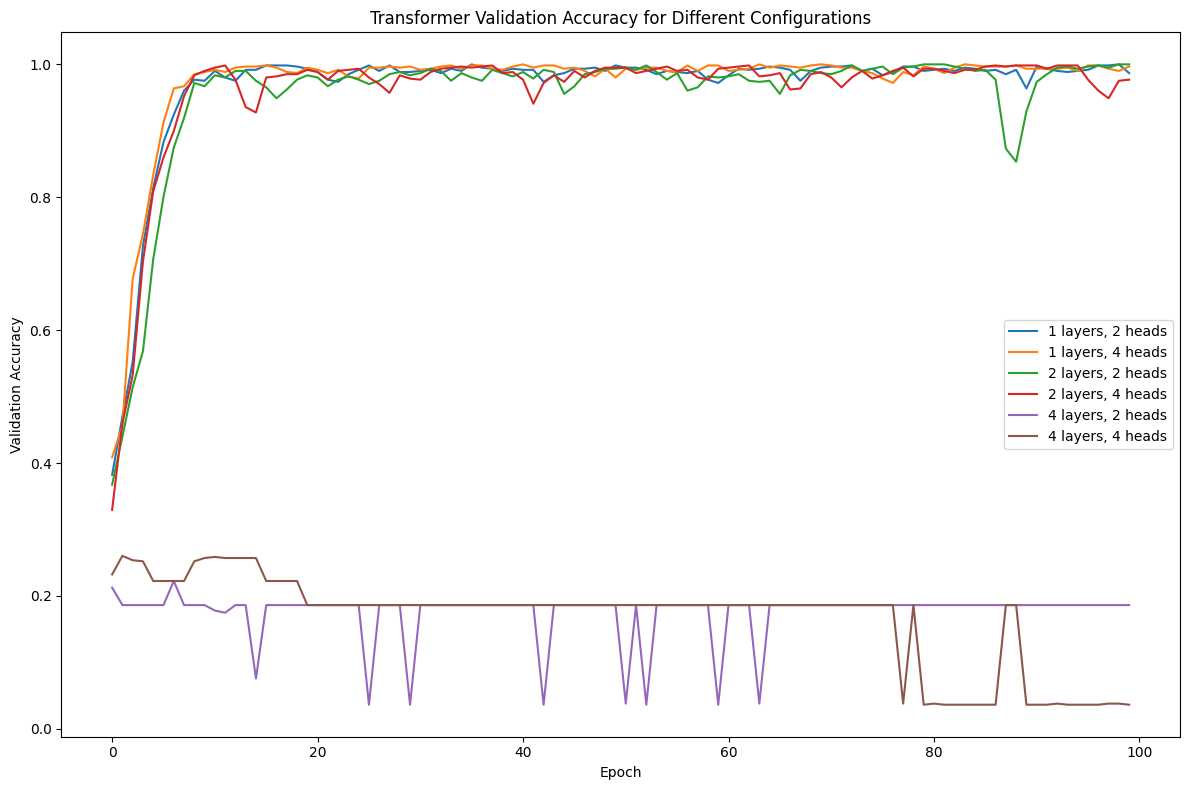

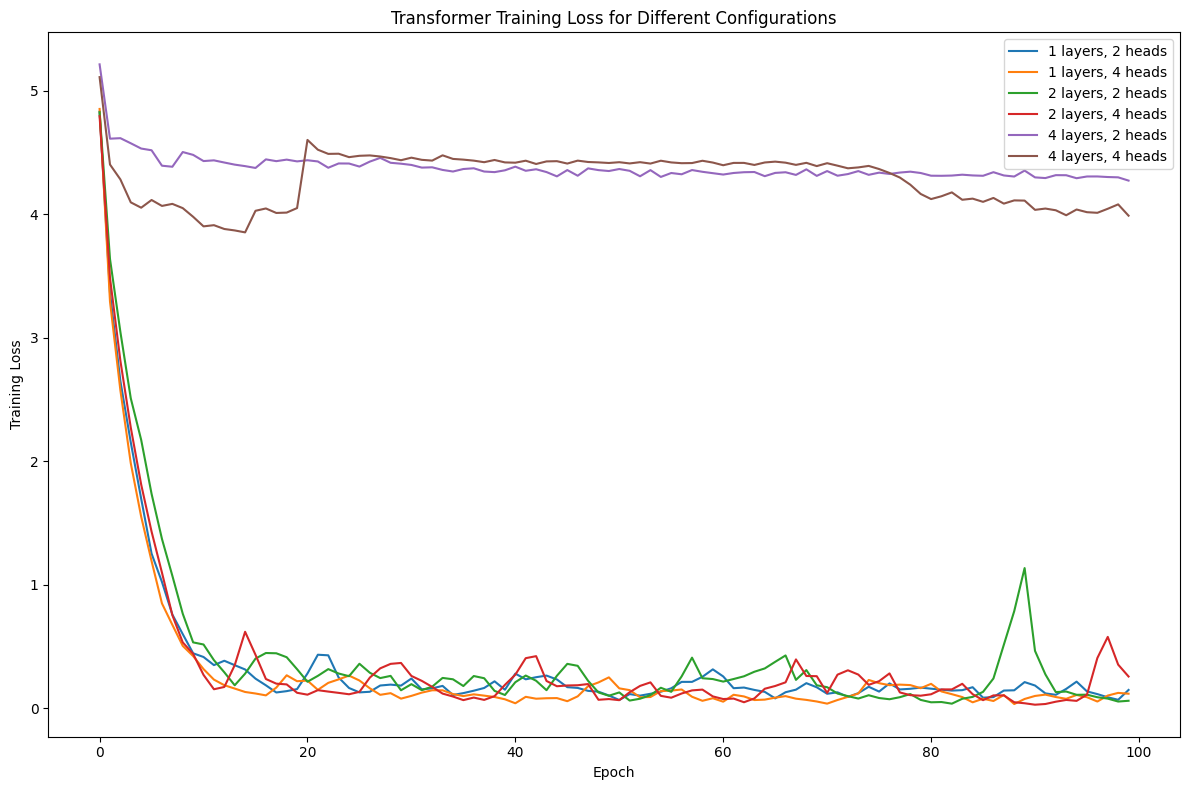

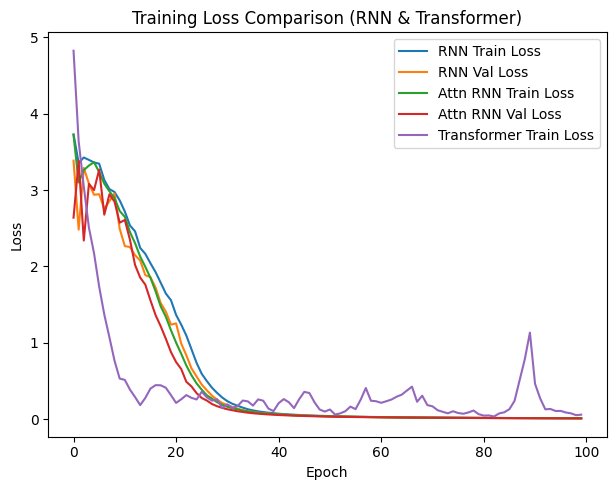

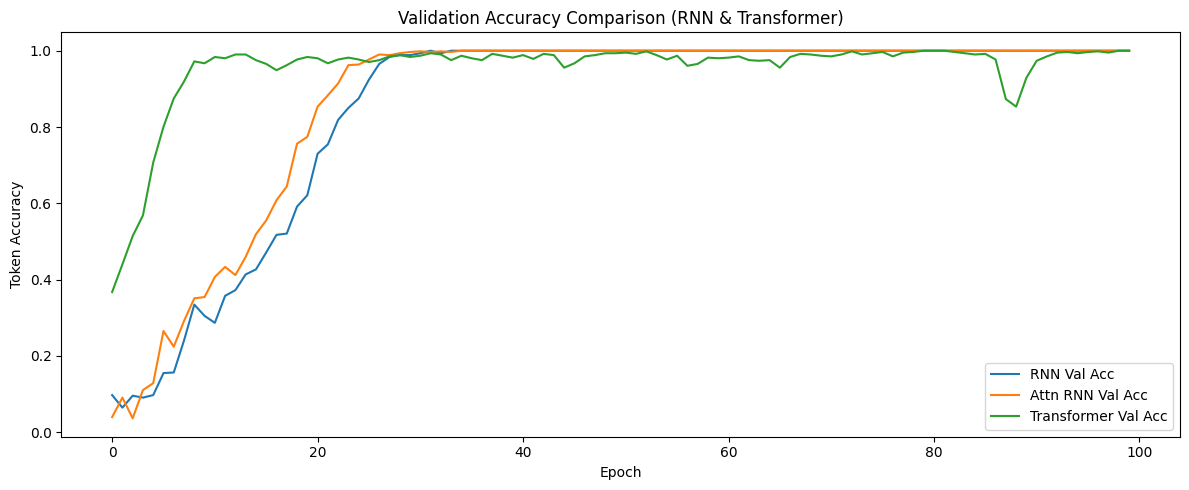

In [16]:
# Plot Transformer validation accuracy for all configurations
plt.figure(figsize=(12, 8))
for res in transformer_results:
    label = f"{res['n_layers']} layers, {res['n_heads']} heads"
    plt.plot(range(n_epochs_trans), res['val_accuracies'], label=label)
plt.xlabel('Epoch')
plt.ylabel('Validation Accuracy')
plt.title('Transformer Validation Accuracy for Different Configurations')
plt.legend()
plt.tight_layout()
plt.savefig("images/hw5_p4_transformer_configs_accuracy.png")
plt.show()

# Plot Transformer training loss for all configurations
plt.figure(figsize=(12, 8))
for res in transformer_results:
    label = f"{res['n_layers']} layers, {res['n_heads']} heads"
    plt.plot(range(n_epochs_trans), res['train_losses'], label=label)
plt.xlabel('Epoch')
plt.ylabel('Training Loss')
plt.title('Transformer Training Loss for Different Configurations')
plt.legend()
plt.tight_layout()
plt.savefig("images/hw5_p4_transformer_configs_loss.png")
plt.show()

# Now, for overall comparison, overlay the best (or average) Transformer curve with the RNN-based models:
plt.figure(figsize=(12, 5))
plt.subplot(1,2,1)
plt.plot(range(n_epochs), rnn_train_losses, label='RNN Train Loss')
plt.plot(range(n_epochs), rnn_val_losses, label='RNN Val Loss')
plt.plot(range(n_epochs), attn_train_losses, label='Attn RNN Train Loss')
plt.plot(range(n_epochs), attn_val_losses, label='Attn RNN Val Loss')

selected_trans = None
for res in transformer_results:
    if res['n_layers'] == 2 and res['n_heads'] == 2:
        selected_trans = res
        break
if selected_trans is not None:
    plt.plot(range(n_epochs_trans), selected_trans['train_losses'], label='Transformer Train Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training Loss Comparison (RNN & Transformer)')
plt.legend()
plt.tight_layout()
plt.savefig("images/hw5_p4_loss_comparison.png")
plt.show()

plt.figure(figsize=(12, 5))
plt.plot(range(n_epochs), rnn_val_accuracies, label='RNN Val Acc')
plt.plot(range(n_epochs), attn_val_accuracies, label='Attn RNN Val Acc')
if selected_trans is not None:
    plt.plot(range(n_epochs_trans), selected_trans['val_accuracies'], label='Transformer Val Acc')
plt.xlabel('Epoch')
plt.ylabel('Token Accuracy')
plt.title('Validation Accuracy Comparison (RNN & Transformer)')
plt.legend()
plt.tight_layout()
plt.savefig("images/hw5_p4_accuracy_comparison.png")
plt.show()

In [15]:
# Sample translations for each model
def translate_rnn(input_tensor, encoder, decoder):
    encoder_hidden = encoder.initHidden()
    input_length = input_tensor.size(0)
    for ei in range(input_length):
        encoder_output, encoder_hidden = encoder(input_tensor[ei].unsqueeze(0), encoder_hidden)
    decoder_input = torch.tensor([SOS_token], device=device)
    decoder_hidden = encoder_hidden
    predicted_indices = []
    while True:
        decoder_output, decoder_hidden = decoder(decoder_input, decoder_hidden)
        topv, topi = decoder_output.topk(1)
        predicted_indices.append(topi.item())
        decoder_input = topi.squeeze().detach()
        if decoder_input.item() == EOS_token or len(predicted_indices) > 50:
            break
    return predicted_indices

def translate_attn(input_tensor, encoder, decoder, max_length=50):
    encoder_hidden = encoder.initHidden()
    input_length = input_tensor.size(0)
    encoder_outputs = torch.zeros(max_length, encoder.hidden_size, device=device)
    for ei in range(input_length):
        encoder_output, encoder_hidden = encoder(input_tensor[ei].unsqueeze(0), encoder_hidden)
        if ei < max_length:
            encoder_outputs[ei] = encoder_output[0, 0]
    decoder_input = torch.tensor([SOS_token], device=device)
    decoder_hidden = encoder_hidden
    predicted_indices = []
    while True:
        decoder_output, decoder_hidden, attn_weights = decoder(decoder_input, decoder_hidden, encoder_outputs)
        topv, topi = decoder_output.topk(1)
        predicted_indices.append(topi.item())
        decoder_input = topi.squeeze().detach()
        if decoder_input.item() == EOS_token or len(predicted_indices) > 50:
            break
    return predicted_indices

def translate_transformer(model, src_sentence, max_len=50):
    model.eval()
    with torch.no_grad():
        # src_sentence is a tensor from the source sequence (with EOS token)
        src = src_sentence.unsqueeze(0).to(device)  # (1, src_len)
        memory = model.encoder(src)
        # Start decoding with SOS token
        tgt_indices = [SOS_token]
        for i in range(max_len):
            tgt = torch.tensor(tgt_indices, dtype=torch.long).unsqueeze(0).to(device)
            tgt_mask = generate_square_subsequent_mask(tgt.size(1)).to(device)
            output = model.decoder(tgt, memory, tgt_mask=tgt_mask)
            next_token = output[0, -1].argmax().item()
            tgt_indices.append(next_token)
            if next_token == EOS_token:
                break
        return tgt_indices

# Display sample translations (show 3 examples)
print("\nSample Translations:")
num_examples = 3
sample_count = 0
for input_tensor, target_tensor in dataloader:
    input_tensor = input_tensor.squeeze(0).to(device)
    target_tensor = target_tensor.squeeze(0).to(device)
    
    # RNN (without attention)
    pred_rnn = translate_rnn(input_tensor, encoder_gru, decoder_gru)
    # RNN with attention
    pred_attn = translate_attn(input_tensor, encoder_attn, decoder_attn, max_length=50)
    # Transformer using the "base" model (if needed)
    pred_trans_base = translate_transformer(transformer_model, input_tensor, max_len=50)
    
    # For p4, source is French and target is English
    src_sentence = " ".join([index_to_word[idx.item()] for idx in input_tensor if idx.item() not in [SOS_token, EOS_token]])
    tgt_sentence = " ".join([index_to_word[idx.item()] for idx in target_tensor if idx.item() not in [SOS_token, EOS_token]])
    pred_sentence_rnn = " ".join([index_to_word[idx] for idx in pred_rnn if idx not in [SOS_token, EOS_token]])
    pred_sentence_attn = " ".join([index_to_word[idx] for idx in pred_attn if idx not in [SOS_token, EOS_token]])
    pred_sentence_trans_base = " ".join([index_to_word[idx] for idx in pred_trans_base if idx not in [SOS_token, EOS_token]])
    
    print("Source   (French):", src_sentence)
    print("Target   (English):", tgt_sentence)
    print("RNN Pred :", pred_sentence_rnn)
    print("Attn Pred:", pred_sentence_attn)
    print("Transformer (base) Pred:", pred_sentence_trans_base)
    
    # Now display predictions for each Transformer configuration
    for config in transformer_results:
        label = f"Transformer ({config['n_layers']} layers, {config['n_heads']} heads)"
        model_config = config['model']
        pred_trans = translate_transformer(model_config, input_tensor, max_len=50)
        pred_sentence_trans = " ".join([index_to_word[idx] for idx in pred_trans if idx not in [SOS_token, EOS_token]])
        print(label, "Pred:", pred_sentence_trans)
    
    print("-" * 50)
    sample_count += 1
    if sample_count >= num_examples:
        break


Sample Translations:
Source   (French): Ils nagent dans la piscine
Target   (English): They swim in the pool
RNN Pred : They swim in the pool
Attn Pred: They swim in the pool
Transformer (base) Pred: au picnic teaches ferme love voler hungry souvent teaches ferme soleil Paris paints parlons meows set soupe jour aime hungry friends are dances peint voler Paris paints parlons meows set les grandparents sable souvent films hair teaches froid work book sable dans sable dans sable dans sable dans sable dans
Transformer (1 layers, 2 heads) Pred: They swim in the pool
Transformer (1 layers, 4 heads) Pred: They swim in the pool
Transformer (2 layers, 2 heads) Pred: They swim in the pool
Transformer (2 layers, 4 heads) Pred: They swim in the pool
Transformer (4 layers, 2 heads) Pred: 
Transformer (4 layers, 4 heads) Pred: She She She She She She She She She She She She She She She She She She She She She She She She She She She She She She She She She She She She She She She She She She She Sh